# 1. Load saved data from Part 1

The following code assumes the notebooks for Part 1 and Part 2 were executed, or the outputs from Part 1 and Part 2 were downloaded from [Google Drive](https://drive.google.com/drive/folders/1zfT8Hlp32RHILd6cNq0CZ3pTM7m1A7vS?usp=sharing) and saved into the mounted Google Drive. It assume there is a folder "facial_recognition" inside the mounted GoogleDrive, and that inside that folder, there are subfolders: "resources" and "results". It also assumes the saved weights from Part 2 were selected based on minimal val_loss and saved in folder "finalized_weights".

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


keras version: 2.3.0-tf
X_dev: (1049, 96, 96, 1)
Y_dev_knn: (1049, 30)


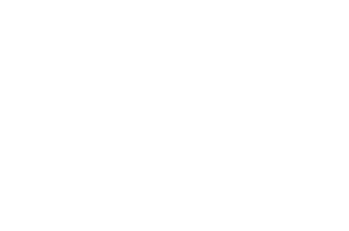

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import pickle

print(f"keras version: {keras.__version__}")
%matplotlib inline
plt.style.use('ggplot')
plt.axis('off')
IMAGE_WIDTH = 96

np.random.seed(0)

# load data
X_dev = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/dev_img.pkl", "rb" ) )
Y_dev_ffill = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/dev_kp_ffill.pkl", "rb" ) )
Y_dev_median = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/dev_kp_median.pkl", "rb" ) )
Y_dev_knn = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/dev_kp_knn.pkl", "rb" ) )
X_test = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/test_img.pkl", "rb" ) )

print('X_dev:', X_dev.shape)
print('Y_dev_knn:', Y_dev_knn.shape)

# 2. Load trained weights from Part 2

In [0]:
def create_naive_LeNet5_model(input_shape):
  # helper function that creates a LeNet5 CNN model, input is an integer indicating the shape of each training input
  model = keras.Sequential()
  model.add(keras.layers.InputLayer(input_shape))
  model.add(keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=120, activation='relu'))
  model.add(keras.layers.Dense(units=84, activation='relu'))
  model.add(keras.layers.Dense(units=30))
  return model

def create_vgg16_model_single_channel(input_shape, use_imagenet = False):
  # convert the grayscale input layer to rgb channels
  single_channel_input = keras.layers.Input(shape=input_shape)
  single_channel_concat = keras.layers.concatenate([single_channel_input,single_channel_input,single_channel_input])

  # load VGG16, either with or without pre_trained weights from ImageNet
  if use_imagenet:
    model_layer = keras.applications.VGG16(weights="imagenet", include_top=False)(single_channel_concat)
  else:
    model_layer = keras.applications.VGG16(weights=None, include_top=False)(single_channel_concat)

  # Flatten the output layer to 1 dimension
  x = keras.layers.Flatten()(model_layer)

  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = keras.layers.Dense(1024, activation='relu')(x)

  # Add a dropout rate of 0.2
  x = keras.layers.Dropout(0.2)(x)

  # Add a final sigmoid layer for classification
  x = keras.layers.Dense (30)(x) 
  model = keras.Model(single_channel_input, x) 
  return model

### 2.1 LeNet5 + ffill

In [0]:
# create and compile model
LeNet5_ffill = create_naive_LeNet5_model(X_dev.shape[1:])
LeNet5_ffill.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# load saved weights
LeNet5_ffill.load_weights("/content/drive/My Drive/facial_recognition/finalized_weights/LeNet5_ffill_try26_ep19.h5")

### 2.2 LeNet5 + median

In [0]:
LeNet5_median = create_naive_LeNet5_model(X_dev.shape[1:])
LeNet5_median.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

LeNet5_median.load_weights("/content/drive/My Drive/facial_recognition/finalized_weights/LeNet5_median_try36_ep14.h5")

### 2.3 LeNet5 + knn

In [0]:
LeNet5_knn = create_naive_LeNet5_model(X_dev.shape[1:])
LeNet5_knn.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

LeNet5_knn.load_weights("/content/drive/My Drive/facial_recognition/finalized_weights/LeNet5_knn_try40_ep32.h5")

### 2.4 VGG16 + knn

In [0]:
VGG16_knn = create_vgg16_model_single_channel(X_dev.shape[1:])
VGG16_knn.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

VGG16_knn.load_weights("/content/drive/My Drive/facial_recognition/finalized_weights/VGG16_knn_try8_ep12.h5")

### 2.5 VGG16 + ImageNet + knn

In [0]:
VGG16_imagenet_knn = create_vgg16_model_single_channel(X_dev.shape[1:])
VGG16_imagenet_knn.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

VGG16_imagenet_knn.load_weights("/content/drive/My Drive/facial_recognition/finalized_weights/VGG16_imagenet_knn_try33_ep81.h5")

# 3. Evaluate model performance

In [0]:
def plot_images(img_array, kp_predicted, kp_train = None):
  # kp_train is the original data points with missing data points
  # kp_predicted is the key point coordinates with missing values filled

  fig, ax = plt.subplots(3,3, figsize=(15,15))
  plt.setp(ax, xticks=(), yticks=())  

  # each row in img_array is a picture
  for row in range(9):   
      image = img_array[row,:].reshape(96, 96)

      # plot image at the appropriate subplot coordinate
      i = int(np.floor(row/3))
      j = int(np.mod(row,3))
      ax[i,j].imshow(image, cmap="gray")

      # create tuples for each key point, each tuple is a pair of x, y
      curr_kp_predicted = kp_predicted[row,:]    
      kp_predicted_zipped = list(zip(curr_kp_predicted[::2], curr_kp_predicted[1::2]))

      if isinstance(kp_train, np.ndarray):
          curr_kp_train = kp_train[row,:]
          kp_train_zipped = list(zip(curr_kp_train[::2], curr_kp_train[1::2]))

          # plot the real data points as green crosses
          for p in kp_train_zipped:
              ax[i,j].scatter(p[0], p[1], s=80, c='#33a02c', marker='P')

      # plot the predicted points as pink circlees
      for p in kp_predicted_zipped:
          ax[i,j].scatter(p[0], p[1], s=60, c='#fb9a99', marker='o', alpha = 0.7)

  plt.show()

### 3.1 LeNet5 + ffill

33/33 [==============================] - 0s 3ms/step - loss: 18.3335 - mae: 3.1467


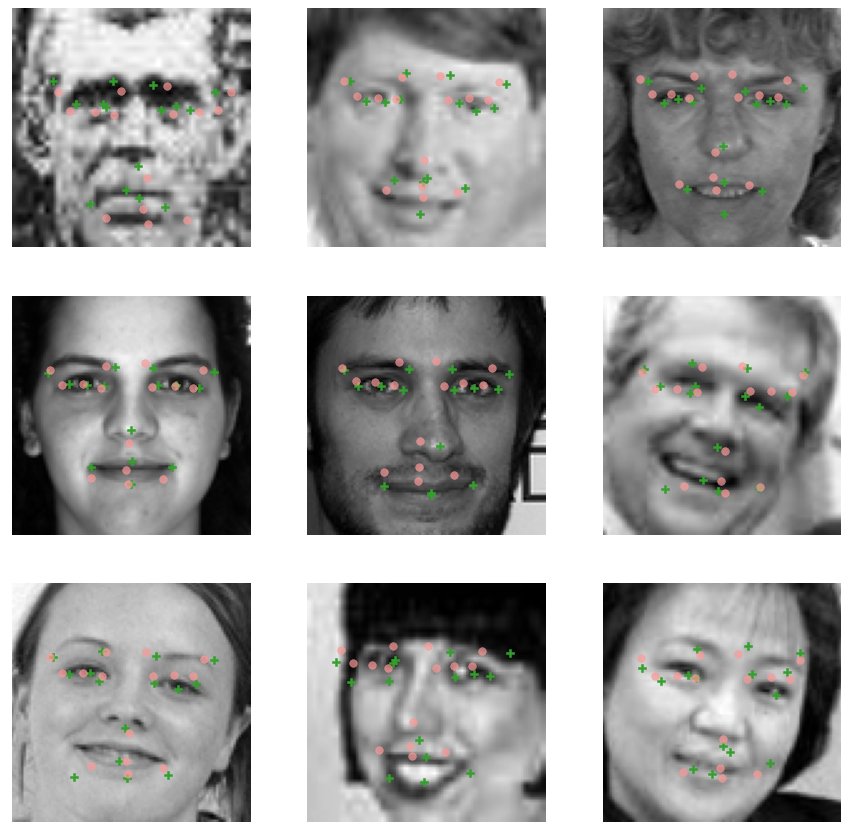

In [10]:
# evaluate the model
LeNet5_ffill.evaluate(X_dev, Y_dev_ffill)

# make predictions using dev images and visualize the predictions
Y_dev_predicted = LeNet5_ffill.predict(X_dev)

idx = np.random.choice(X_dev.shape[0], size = 9, replace = False).tolist()
plot_images(X_dev[np.array(idx)], Y_dev_predicted[np.array(idx)], kp_train = Y_dev_ffill[np.array(idx)])

### 3.2 LeNet5 + median

33/33 [==============================] - 0s 3ms/step - loss: 16.3242 - mae: 2.9447


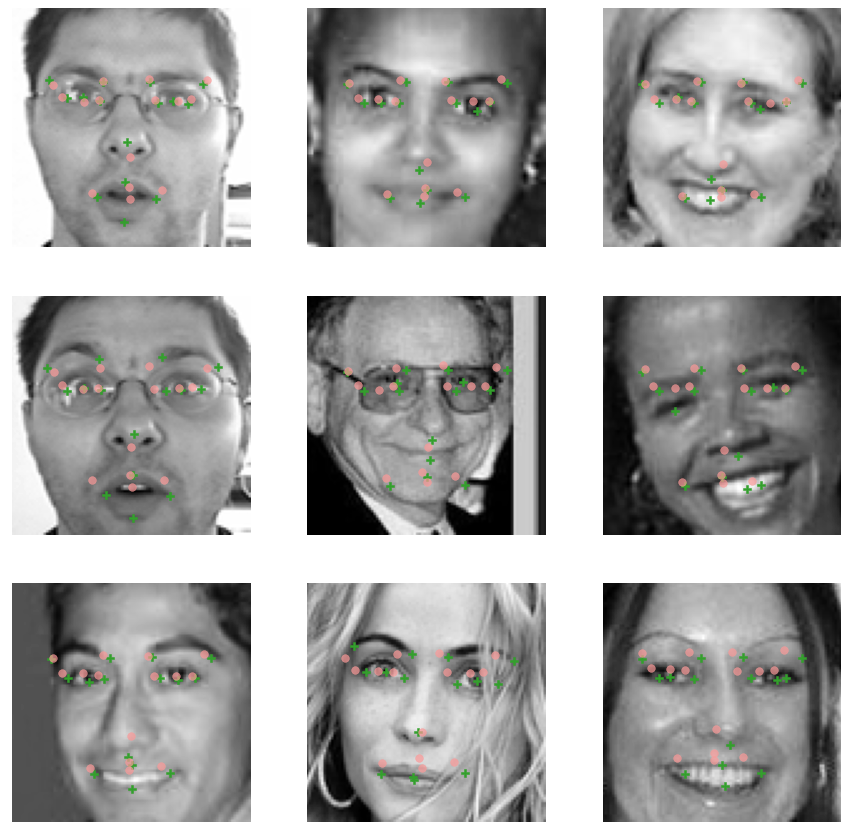

In [17]:
# evaluate the model
LeNet5_median.evaluate(X_dev, Y_dev_median)

# make predictions using dev images and visualize the predictions
Y_dev_predicted = LeNet5_median.predict(X_dev)

idx = np.random.choice(X_dev.shape[0], size = 9, replace = False).tolist()
plot_images(X_dev[np.array(idx)], Y_dev_predicted[np.array(idx)], kp_train = Y_dev_median[np.array(idx)])

### 3.3 LeNet5 + knn

33/33 [==============================] - 0s 3ms/step - loss: 19.6367 - mae: 3.2228


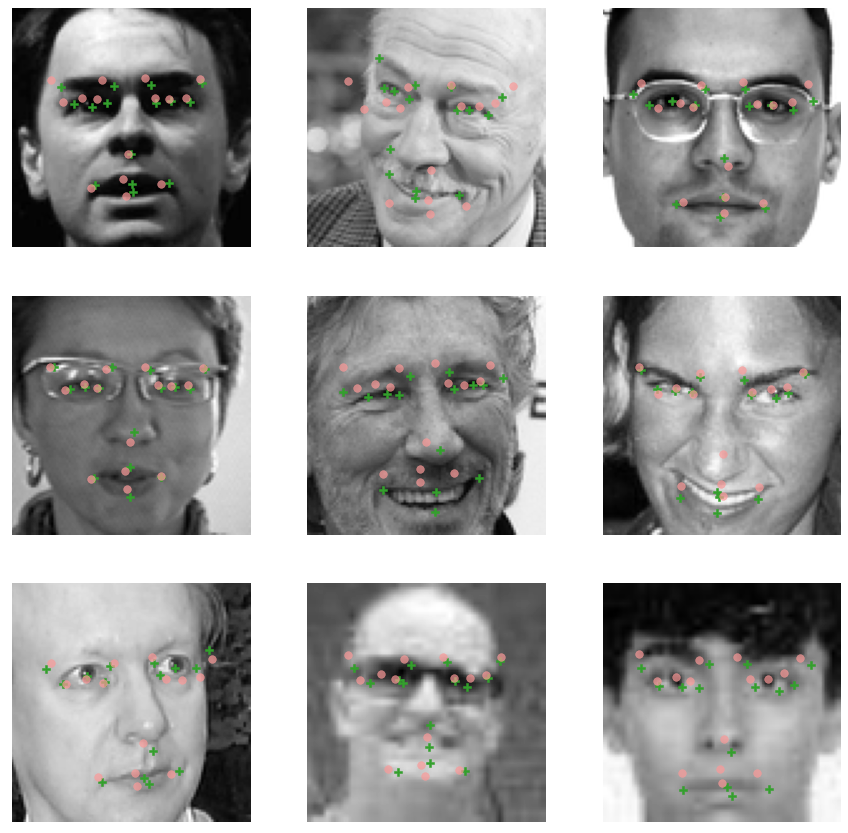

In [19]:
# evaluate the model
LeNet5_knn.evaluate(X_dev, Y_dev_knn)

# make predictions using dev images and visualize the predictions
Y_dev_predicted = LeNet5_knn.predict(X_dev)

idx = np.random.choice(X_dev.shape[0], size = 9, replace = False).tolist()
plot_images(X_dev[np.array(idx)], Y_dev_predicted[np.array(idx)], kp_train = Y_dev_knn[np.array(idx)])

### 3.4 VGG16 + knn

33/33 [==============================] - 1s 24ms/step - loss: 11.0819 - mae: 2.1642


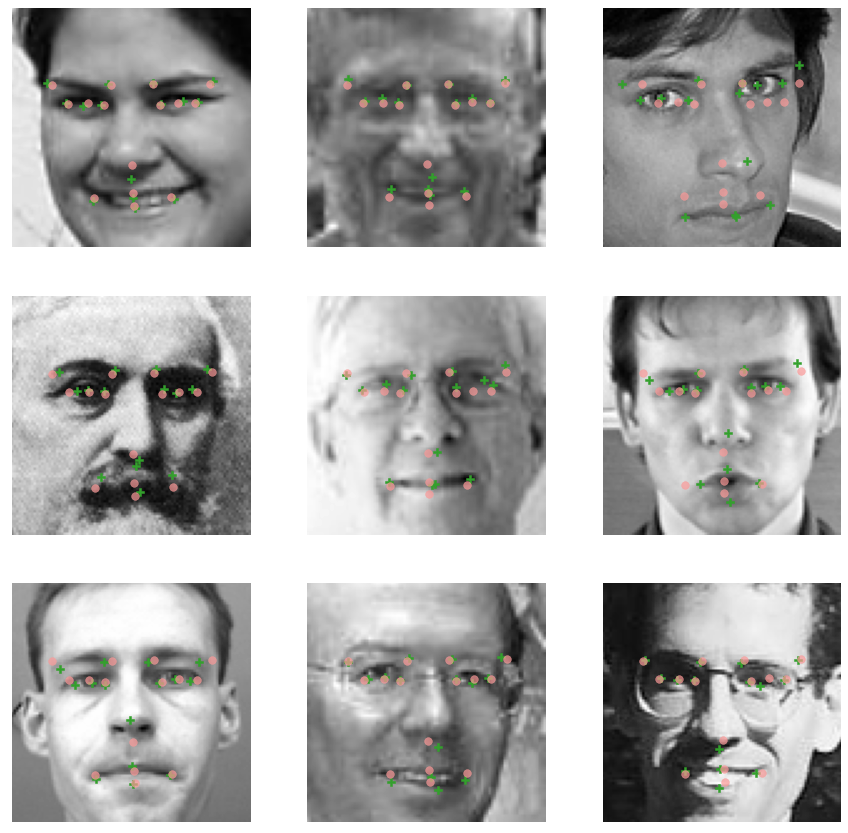

In [13]:
# evaluate the model
VGG16_knn.evaluate(X_dev, Y_dev_knn)

# make predictions using dev images and visualize the predictions
Y_dev_predicted = VGG16_knn.predict(X_dev)

idx = np.random.choice(X_dev.shape[0], size = 9, replace = False).tolist()
plot_images(X_dev[np.array(idx)], Y_dev_predicted[np.array(idx)], kp_train = Y_dev_knn[np.array(idx)])

### 3.5 VGG16 + ImageNet + KNN

33/33 [==============================] - 1s 19ms/step - loss: 5.2478 - mae: 1.4338


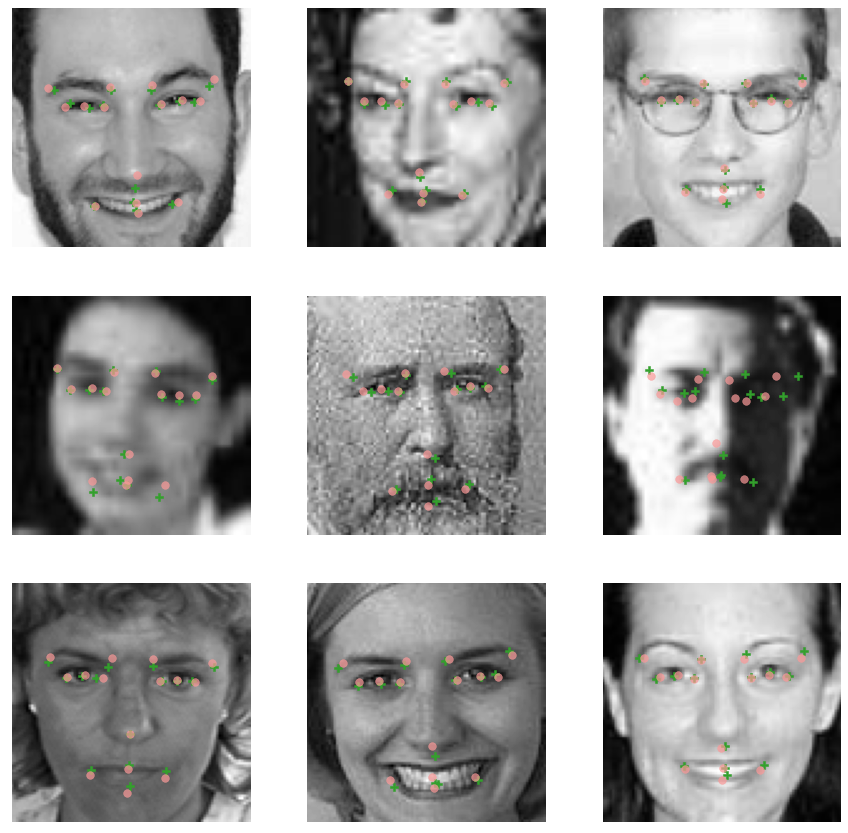

In [21]:
# evaluate the model
VGG16_imagenet_knn.evaluate(X_dev, Y_dev_knn)

# make predictions using dev images and visualize the predictions
Y_dev_predicted = VGG16_imagenet_knn.predict(X_dev)

idx = np.random.choice(X_dev.shape[0], size = 9, replace = False).tolist()
plot_images(X_dev[np.array(idx)], Y_dev_predicted[np.array(idx)], kp_train = Y_dev_knn[np.array(idx)])

# 4. Use best model on test set

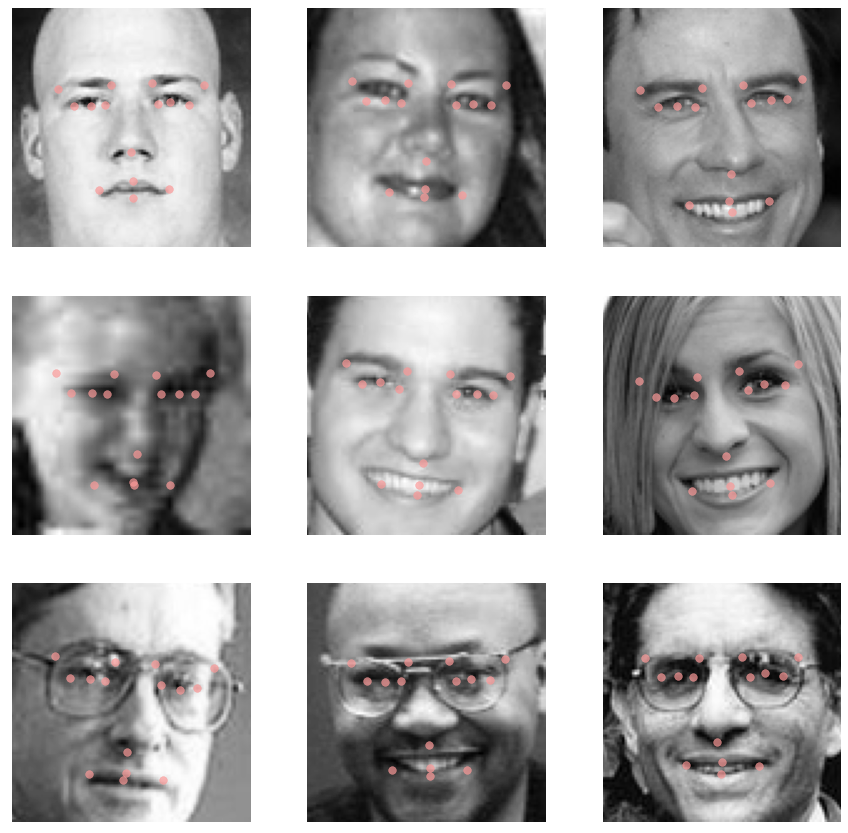

In [26]:
Y_test_predicted = VGG16_imagenet_knn.predict(X_test)

idx = np.random.choice(X_test.shape[0], size = 9, replace = False).tolist()
plot_images(X_test[np.array(idx)], Y_test_predicted[np.array(idx)])

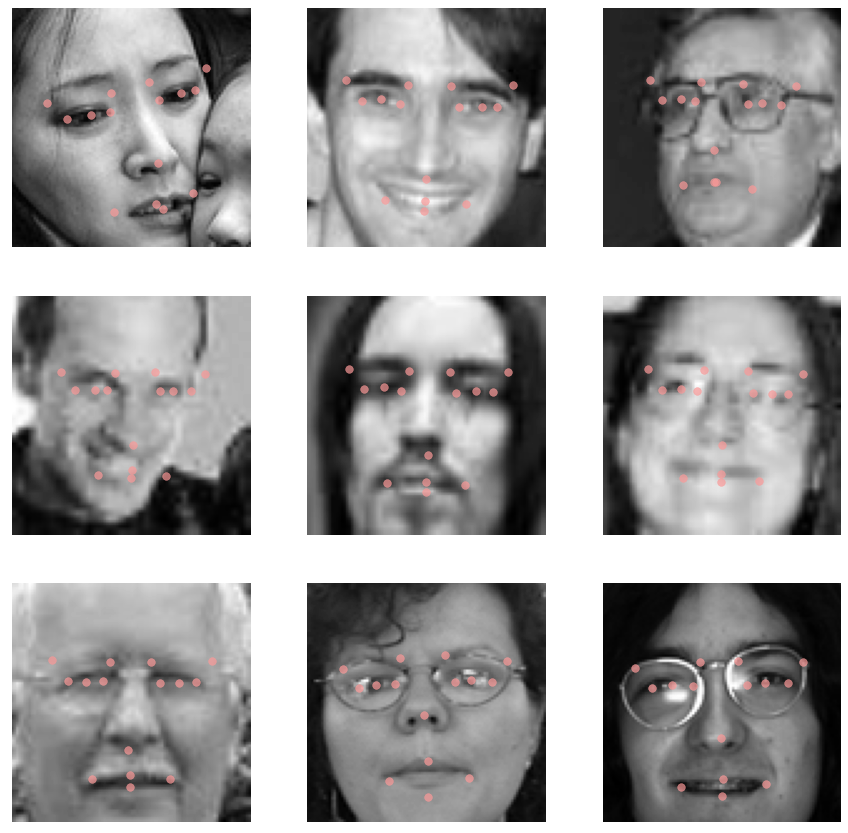

In [29]:
idx = np.random.choice(X_test.shape[0], size = 9, replace = False).tolist()
plot_images(X_test[np.array(idx)], Y_test_predicted[np.array(idx)])